In [235]:
import os
import datetime
import pygrib
import pickle
import numpy as np
import pygrib
import matplotlib.pyplot as plt
from matplotlib.dates import DayLocator, HourLocator, DateFormatter, drange
plt.style.use('seaborn-poster')
%matplotlib inline
def _getting_valid_matrix(series, time):
    # There are two types of matrix, matrix with values or masked matrix, 
    # masked matrix should be filled with -999.0, like no valid data.
    # if it is VIL, then we will fill it with 0.0, 
    # cloudtop, we will fill it with -999.0
    if type(series[time]) == np.ma.core.MaskedArray:
        name = series["name"]
        if name == "VIL":
            retn = series[time].filled(-999.0)
        if name == "cloudtop":
            retn = series[time].filled(0.0)     
    else: 
        retn = series[time]

    return retn

def series_show(series):
    for i in range(12):
        fig, axs = plt.subplots(1,8,figsize=(15,15))
        for j in range(8):
            time = (i*2 + j//4)*100 + j%4*15
            try:
                mat = _getting_valid_matrix(series,time)
                if series["name"] == "Density":
                    shw = axs[j].imshow(mat,vmin=0,vmax=3.0)
                else:
                    shw = axs[j].imshow(mat)
                axs[j].set_title('{}_{:<4}'.format(series["name"],time))
            except:
                print('\x1b[6;30;41m'+ f"Warning: Not found the data at {time}. Please contact with the author."+'\x1b[0m')
        fig.subplots_adjust(right=0.85)
        cbar_ax = fig.add_axes([0.88, 0.47, 0.02, 0.07])
        fig.colorbar(shw, cax=cbar_ax)
        plt.show()

def generate_VIL_density_matrix(cloudtop,VIL):
    VIL_density = {}
    VIL_density["name"]="Density"
    for i in range(24):
        for j in [0,15,30,45]:
            time = i*100+j
            # Checking
            try:
                #Verifying the shape is correct
                if (VIL[time].shape != (100,100)) or (cloudtop[time].shape != (100,100)):
                    print('\x1b[6;30;41m'+ "Warning: The shape of VIL or cloudtop is wrong!"+'\x1b[0m')
            except:
                print('\x1b[6;30;41m'+ f"Warning: the data of VIL or cloudtop at {time} is lost."\
                      +'\x1b[0m')
            #filling the mask matrix
            cloudtop_mat = _getting_valid_matrix(cloudtop,time)
            VIL_mat = _getting_valid_matrix(VIL,time)
            VIL_density[time] = np.divide(VIL_mat,cloudtop_mat,out=np.zeros_like(VIL_mat), where=cloudtop_mat!=0.0)
            VIL_density[time] = 1000.0*VIL_density[time]
    return VIL_density
cur_location = os.getcwd()

In [338]:
start_date = datetime.date(2021, 4, 1)
end_date = datetime.date(2021, 5, 1)
time_between_dates = end_date - start_date
days_between_dates = time_between_dates.days

In [339]:
max_density_sequence = {}
for i in range(days_between_dates):
    current_date = start_date + datetime.timedelta(days=i)    
    str_date = "hrrr{}-{:0>2}-{:0>2}".format(current_date.year, current_date.month, current_date.day)
    with open(cur_location+'/hrrrdata/'+str_date+'.dat','rb') as f:
        (cloudtop, VIL, names) = pickle.load(f)
        # self check
        if len(set(names))!= 2:
            print('\x1b[6;30;41m'+ "Warning: The data is not correct, Because either cloudtop or VIL is lost!"+'\x1b[0m')
        cloudtop["name"] = "cloudtop"
        VIL["name"] = "VIL"
    VIL_density = generate_VIL_density_matrix(cloudtop,VIL)
    for i in range(24):
        for j in [0,15,30,45]:
            time = i*100+j
            max_density_sequence[str_date+'-'+str(time)]=np.max(VIL_density[time])


In [340]:
delta = datetime.timedelta(seconds=900)
dates = drange(start_date, end_date, delta)

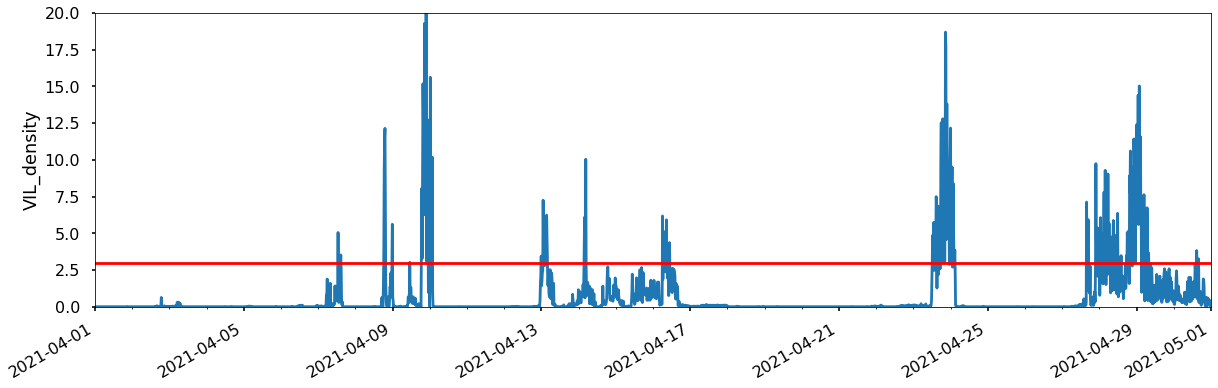

In [369]:
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(dates,max_density_sequence.values())
ax.set_xlim(dates[0], dates[-1])
ax.xaxis.set_minor_locator(DayLocator())
ax.xaxis_date()     # interpret the x-axis values as dates
fig.autofmt_xdate() # make space for and rotate the x-axis tick labels
plt.ylabel('VIL_density')
plt.ylim([0, 20])
#A second line
plt.axhline(y=3.0, color='r', linestyle='-')
plt.show()

In [370]:
x =list(max_density_sequence.values())

In [371]:
#check if there is any nan\inf
print(np.isnan(x).any(),np.isinf(x).any())

False False


/Users/binshuaiwang/PycharmProjects/WeatherPrediction/venv/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Passing the linefmt parameter positionally is deprecated since Matplotlib 3.5; the parameter will become keyword-only two minor releases later.
  del sys.path[0]


(0.0, 1000.0)

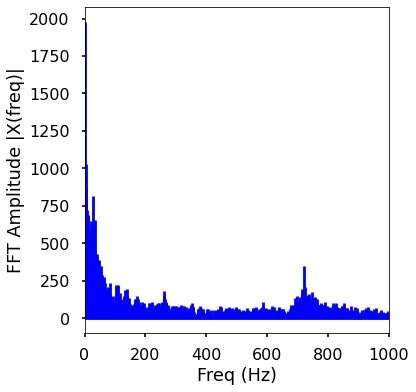

In [373]:
from numpy.fft import fft, ifft

X = fft(x)
N = len(X)
n = np.arange(N)
T = N/len(x)
freq = n/T 

plt.figure(figsize = (12, 6))
plt.subplot(121)

plt.stem(freq, np.abs(X), 'b', \
         markerfmt=" ", basefmt="-b")
plt.xlabel('Freq (Hz)')
plt.ylabel('FFT Amplitude |X(freq)|')
plt.xlim(0, 1000)


/Users/binshuaiwang/PycharmProjects/WeatherPrediction/venv/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Passing the linefmt parameter positionally is deprecated since Matplotlib 3.5; the parameter will become keyword-only two minor releases later.
  


(0.0, 1000.0)

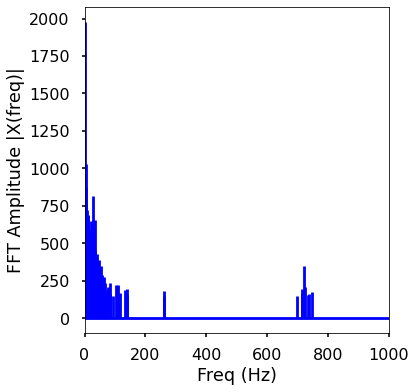

In [407]:
threshold = 150
X_idxs = np.abs(X) > threshold #array of 0 and 1
X_clean = X * X_idxs #zero out all the unnecessary powers
plt.figure(figsize = (12, 6))
plt.subplot(121)

plt.stem(freq, np.abs(X_clean), 'b', 
         markerfmt=" ", basefmt="-b")
plt.xlabel('Freq (Hz)')
plt.ylabel('FFT Amplitude |X(freq)|')
plt.xlim(0, 1000)

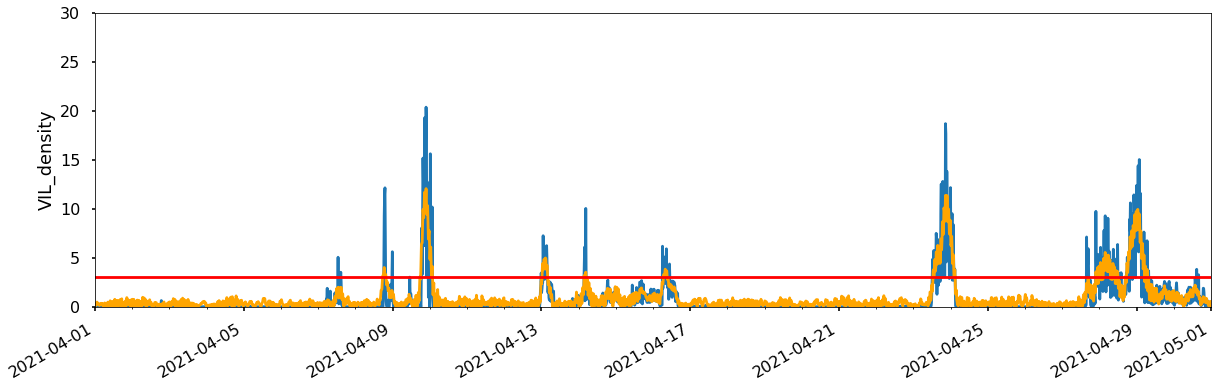

In [408]:
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(dates,max_density_sequence.values())
ax.plot(dates,np.abs(ifft(X_clean)),color='orange')
ax.set_xlim(dates[0], dates[-1])
ax.xaxis.set_minor_locator(DayLocator())
ax.xaxis_date()     # interpret the x-axis values as dates
fig.autofmt_xdate() # make space for and rotate the x-axis tick labels
plt.ylabel('VIL_density')
plt.ylim([0, 30])
#A second line
plt.axhline(y=3.0, color='r', linestyle='-')
plt.show()

In [409]:
x_clean=ifft(X_clean)
x_clean

array([-0.23139229-1.48029737e-17j, -0.33188262+2.61519201e-16j,
       -0.20622178+9.37521665e-17j, ..., -0.54866472+4.96244836e-16j,
       -0.32108811-9.70568665e-17j, -0.12237726+4.56651252e-16j])

In [391]:
max_density_sequence_clean = {}
for (i,x) in enumerate(max_density_sequence):
    max_density_sequence_clean[x] = np.abs(x_clean[i])

In [411]:
max_density_sequence_clean['hrrr2021-04-16-915']

2.740692118041492

In [412]:
max_density_sequence['hrrr2021-04-16-915']

1.9427483783716097

In [413]:
max_density_sequence_clean['hrrr2021-04-16-900']

2.748927318300979

In [414]:
max_density_sequence['hrrr2021-04-16-900']

2.479445401156886